## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  my goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape[0] #the number of rows in the dataset

294478

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique() #The number of unique users in the dataset

290584

d. The proportion of users converted.

In [6]:
df['converted'].mean() #The proportion of users converted

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
df.query("(group == 'treatment' and landing_page != 'new_page') or (group != 'treatment' and landing_page == 'new_page')").shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
df.info() #checking the null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
#making new dataframe where treatment matches new_page and control matches old_page then assigning it to df2
df2 = df.query("(group == 'treatment' and landing_page == 'new_page') or (group == 'control' and landing_page == 'old_page')")

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique() #the unique user_ids in df2

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2['user_id'].duplicated()]['user_id'] #extracting the duplecated ID

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2['user_id'].duplicated()] #extracting the duplecated row

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop(2893 , axis = 0 , inplace = True) #droping the duplicated Id by the index of its row

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [16]:
df2.converted.mean() #the probability of an individual converting regardless of the page they receive

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
#the probability of conversion given that the individual is in control group
df2[df2['group'] == 'control'].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
#the probability of conversion given that the individual is in treatment group
df2[df2['group'] == 'treatment'].converted.mean() 

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
(df2['landing_page'] == 'new_page').mean() #the probability that an individual received the new page

0.50006194422266881

  given that the probability that an individual received the new page is fifty percent and the probability that the individual convertes if they are in the treatment group is the same as the convertion if they are in the control group which is also the same as the whole probability of convertion, then I think **there's no proof or evidence to say thet the new page has a different effect than the old one**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be? 

**null hypothesis :  $p_{old}$ >= $p_{new}$**

**alternative hypothesis :  $p_{old}$ < $p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
ab_data = pd.read_csv('ab_data.csv')

In [21]:
pnew = ab_data.converted.mean() #the conversion rate for 𝑝𝑛𝑒𝑤 under the null
pnew

0.11965919355605512

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
pold = ab_data.converted.mean() #the conversion rate for 𝑝𝑜𝑙𝑑 under the null
pold

0.11965919355605512

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
nnew = df2[df2['group']=='treatment'].shape[0] #the number of individuals in the treatment group
nnew

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
nold = df2[df2['group']=='control'].shape[0] #the number of individuals in the control group
nold

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
#simulating the conversion rate of the new page given the number of treatment group and pnew
new_page_converted = np.random.choice([0,1] , size = nnew, replace = True , p = [1-pnew , pnew] )

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
#simulating the conversion rate of the old page given the number of control group and pold
old_page_converted = np.random.choice([0,1] , size = nold, replace = True , p = [1-pold , pold] )

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
pnew_sim = new_page_converted.mean() #computing the new sampled pnew
pold_sim = old_page_converted.mean() #computing the new sampled pold
pnew_sim - pold_sim #computing the difference between the two means

-0.00051135102786227515

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
p_diffs = []

nnew = ab_data[ab_data['group']=='treatment'].shape[0] #the number of treatment group in ab_data dataset
nold = ab_data[ab_data['group']=='control'].shape[0] #the number of control group in ab_data dataset

for i in range(10000):   
    #simulating the conversion rate of the new page given the number of treatment group and pnew
    new_page_converted = np.random.choice([0,1] , size = nnew, replace = True , p = [1-pnew , pnew] ) 
    #simulating the conversion rate of the old page given the number of control group and pold
    old_page_converted = np.random.choice([0,1] , size = nold, replace = True , p = [1-pold , pold] )

    pnew_sampled = new_page_converted.mean() #computing the new sampled pnew
    pold_sampled = old_page_converted.mean() #computing the new sampled pold
    diff = pnew_sampled - pold_sampled #computing the difference between the two means
    
    p_diffs.append(diff)
    
p_diffs = np.array(p_diffs) #converting the list into numpy array

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  1.70000000e+01,   1.29000000e+02,   7.88000000e+02,
          2.20100000e+03,   3.14800000e+03,   2.45900000e+03,
          1.00000000e+03,   2.23000000e+02,   3.30000000e+01,
          2.00000000e+00]),
 array([-0.00457636, -0.0035828 , -0.00258925, -0.00159569, -0.00060214,
         0.00039142,  0.00138497,  0.00237853,  0.00337208,  0.00436564,
         0.00535919]),
 <a list of 10 Patch objects>)

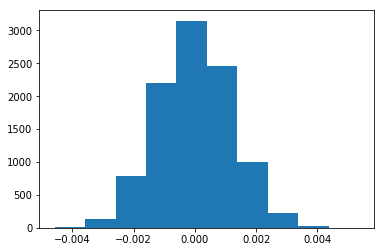

In [29]:
plt.hist(p_diffs) #plotting the histogram of the sample distribuation

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
pnew_obs = ab_data [ab_data['group'] == 'treatment'].converted.mean() #the observed convertion rate in the treatment group
pold_obs = ab_data [ab_data['group'] == 'control'].converted.mean() #the observed convertion rate in the control group
obs_difference = pnew_obs - pold_obs #the difference between the two means

(p_diffs > obs_difference ).mean() #computing the p value

0.88959999999999995

what I have computed now is called **p value**, it's the probability of getting one result or more results which are extereme and different than the observed result that we have of the data given that the null hypothesis is true.  

**the p value we have is about 0.9 which is pretty big. that means that the assumption of null hypothesis can't be rejected based on the data we have therefore the probability the new page doesn't have a signeficant difference from the probability of the old page. the difference is zero or less according to the null hypothesis**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = ab_data[ab_data['landing_page'] == 'old_page'].converted.sum() #the number of conversions in old_page
convert_new = ab_data[ab_data['landing_page'] == 'new_page'].converted.sum() #the number of conversions in new_page
n_old = ab_data[ab_data['landing_page'] == 'old_page'].shape[0] #the number of users old_page
n_new = ab_data[ab_data['landing_page'] == 'new_page'].shape[0] #the number of users new_page

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [32]:
#feeding the function with number of conversions and users in every page
#we used larger alternative as the alternative hypothesis have pnew larger that pold
stat, pval = sm.stats.proportions_ztest([convert_new,convert_old], [n_new,n_old] , alternative = 'larger')

In [33]:
stat

-1.3683341399998907

In [34]:
pval

0.9143962454534289

**the p value is pretty close to p value we have above which also indicates that we can't reject the null hypothesis that the conversion rate of the new page is the same or less than the conversion rate in the old page and the values we have agree with the findings in parts j and k**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [36]:
df2[['control' , 'ab_page']] = pd.get_dummies(df2['group']) #adding the control and ab_page(treatment) dummy variables
df2['intercept'] = 1 # adding the intercept column

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [37]:
logestic_mod = sm.Logit(df2['converted'] , df2 [['ab_page' , 'intercept']]) #identifing the model
fit_logetsic_mod = logestic_mod.fit() #fittin the model to the data

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
fit_logetsic_mod.summary2() #the summary of the model

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-08-17 07:58 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
==================================================================

"""

**the p value is 0.1899.**


**it's different than what is found in part II because it has another meaning. this p value represents whether the feature ab_page has Statistical significance to the conversion rate or not. Appearently it's a significance within 20% type I error**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**we may consider adding more feature to the regression model so that we have more features that have a Statistical significance to the conversion rate but some time there might be some disadvantages to this addition**

**if the features we are adding has no correlation with the conversion rate then the resulted model will be weaker and prone to error and the R squared probably will be smaller**

**if the features we are adding has correlations with each others then we will have multicolinearity in the resulted model which will cause some problems in the model**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
country = pd.read_csv('countries.csv')
country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
#merging the two data sets we have by focusing on the intersection between them in the user id column
df_merged = pd.merge(country ,df2, how = 'inner' ,left_on = 'user_id' , right_on = 'user_id')

In [41]:
df_merged[['CA', 'UK' ,'US']] = pd.get_dummies(df_merged['country']) #making the dummy variables of the countries

In [42]:
df_merged.head()

,user_id,country,timestamp,group,landing_page,converted,control,ab_page,intercept,CA,UK,US
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,0,0,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,0,1,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,0,1,0


In [43]:
logestic_mod = sm.Logit(df_merged['converted'] , df_merged[['CA', 'UK' , 'intercept']]) #identifing the model
fit_logetsic_mod = logestic_mod.fit() #fittin the model to the data
fit_logetsic_mod.summary2() #the summary of the model

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-08-17 07:58 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
==================================================================

"""

**according to the p value of the CA, UK and intercept factors, yes, it does appear that that the countries has some statistical significance on the conversion rate even though the UK factor has a really high p value which indicates the model will work maybe even better without it**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [48]:
df_merged.head()

,user_id,country,timestamp,group,landing_page,converted,control,ab_page,intercept,CA,UK,US,CA_page,UK_page
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,0,0,1,0,0
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,0,1,0,0,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,0,1,0,0,1


In [47]:
df_merged['CA_page'] = df_merged['CA'] * df_merged['ab_page'] #creating new column by multibling CA by ab_page
df_merged['UK_page'] = df_merged['UK'] * df_merged['ab_page'] #creating new column by multibling UK by ab_page

In [49]:
logestic_mod = sm.Logit(df_merged['converted'] , df_merged[['ab_page' , 'CA', 'UK' ,'CA_page' ,'UK_page', 'intercept']]) #identifing the model
fit_logetsic_mod = logestic_mod.fit() #fittin the model to the data
fit_logetsic_mod.summary2() #the summary of the model

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-08-17 08:02 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA_page      -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_page       0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
==================================================================

"""

**W.R.T p value:**
>**both the treatment and the countris may have some kind of statistical signficance to the conversion rate but with high margine of type I error except CA and UK which have a very high error rate unlike the CA_page and UK_page which appear to have a relation with the conversion rate of somekind.
if our threshold of alpha is only 5%, I think the model we have isn't strong enough and prone to high margin of error.**

**W.R.T R squared:** 
>**in all the models we made, the R squared is zero all the time which tells us that the factors we have isn't good enough and our model is very weak**

**W.R.T the coeffs:** 
>**if we look at the coefficients of the features we find that it's unintuative.
the treatment has more chance of 1.02 times to have high conversion rate than the control even though our a/b test showd that they both have a fair chance w.r.t the conversion rate.**

>**note: it's hard to interprete the impact of the countries on the conversion rate only giving the coeffiecients because we have features that have a realtion with the country features like "UK_page" and "CA_page" so the normal interpretetion wouldn't work. but based on the p values it seems that the features "CA" and "UK" has no or weak impact on the conversion code and "CA_page" and "UK_page" have a p value with high margin of Type I error**

### conclusion

**I think the model isn't that great and needs more factors that have a high correlation with the conversion rate or high statistical significance but under the data we have we can't reject the null hypothesis so the final conclusion is that there's no difference between the new page and the old page**

## the final result is the old Page has more conversion rate than the new page